In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torchvision 
from torchvision import transforms
from copy import deepcopy
import torch.nn.functional as F

def load_mnist(batch_size,norm_factor=1):
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.MNIST(root='../data', train=True,
                                            download=True, transform=transform)
    print("trainset: ", trainset)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True)
    print("trainloader: ", trainloader)
    trainset = list(iter(trainloader))

    testset = torchvision.datasets.MNIST(root='../data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=True)
    testset = list(iter(testloader))
    for i,(img, label) in enumerate(trainset):
        trainset[i] = (img.reshape(len(img),784) /norm_factor ,label)
    for i,(img, label) in enumerate(testset):
        testset[i] = (img.reshape(len(img),784) /norm_factor ,label)
    return trainset, testset

trainset, testset = load_mnist(1000)

trainset:  Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
trainloader:  <torch.utils.data.dataloader.DataLoader object at 0x7151b5d10990>


In [17]:
def binarize(img):
  i = deepcopy(img)
  i[img > 0] = -1
  i[img <=0] = 1
  return i

def zero_bottom_half(img):
  i = deepcopy(img)
  H,W = img.shape
  i[H//2:H,:] = -1
  return i

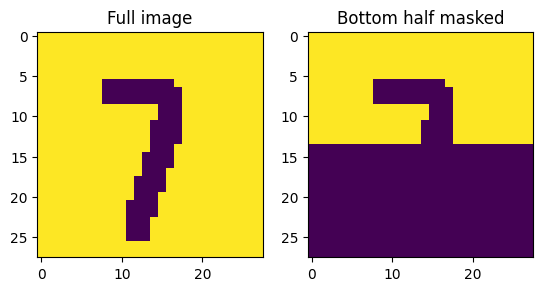

In [18]:
imgs,labels = trainset[0]
digit = imgs[3,:].reshape(784,1)
digit = binarize(digit)
halved_digit = zero_bottom_half(digit.reshape(28,28)).reshape(784,1)
plt.subplot(1,2,1)
plt.title("Full image")
plt.imshow(digit.reshape(28,28))
plt.subplot(1,2,2)
plt.title("Bottom half masked")
plt.imshow(halved_digit.reshape(28,28))
plt.show()

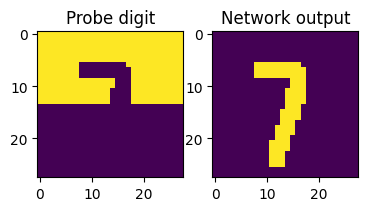

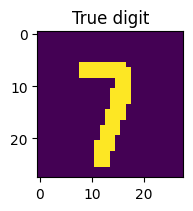

In [19]:
# Store a single digit in the weights
W = digit @ digit.T
# perform the hopfield update rule with the probe as the halved digit to retrieve the original
out = binarize(W @ halved_digit)

#plot
plt.subplot(1,3,1)
plt.title("Probe digit")
plt.imshow(halved_digit.reshape(28,28))
plt.subplot(1,3,2)
plt.title("Network output")
plt.imshow(out.reshape(28,28))
plt.show()
plt.subplot(1,3,3)
plt.title("True digit")
plt.imshow(out.reshape(28,28))
plt.show()

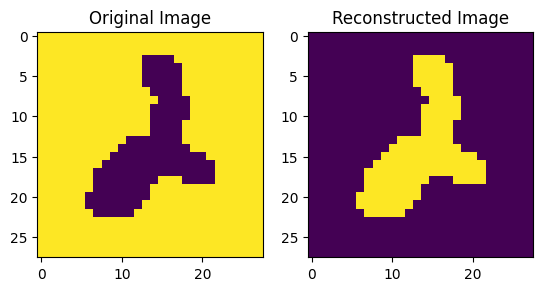

In [20]:
def store_retrieve_N_images(N):
  # construct weight matrix of N stored images
  W = torch.zeros((784,784))
  for i in range(N):
    digit = binarize(imgs[i,:].reshape(784,1))
    W += digit @ digit.T

  # try to retrieve each image
  for i in range(N):
    digit = binarize(imgs[i,:]).reshape(28,28)
    halved_digit = zero_bottom_half(digit).reshape(784,1)
    out = binarize(W @ halved_digit)
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(digit)
    plt.subplot(1,2,2)
    plt.title("Reconstructed Image")
    plt.imshow(out.reshape(28,28))
    plt.show()

store_retrieve_N_images(3)

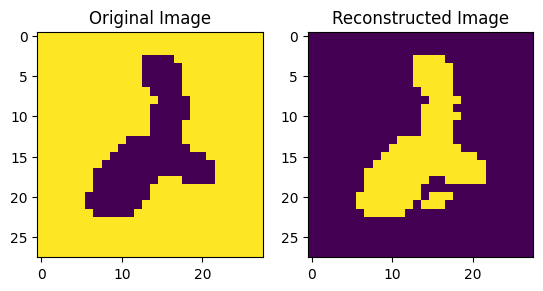

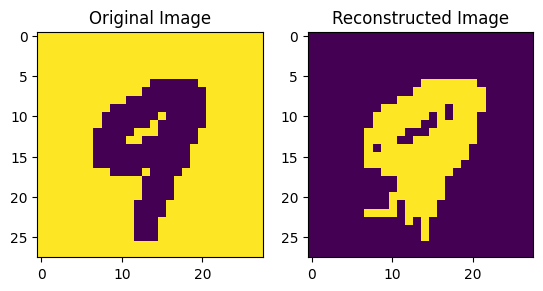

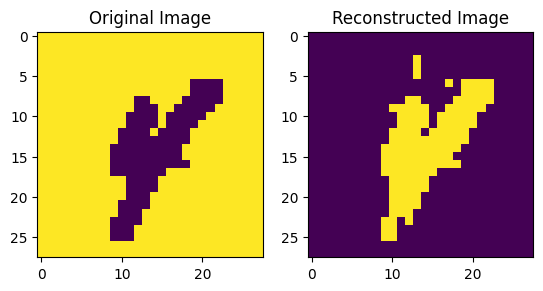

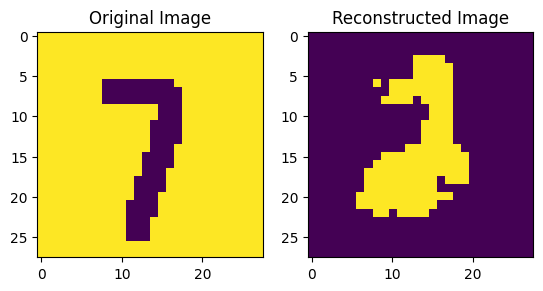

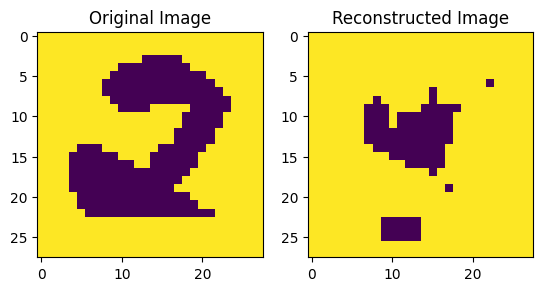

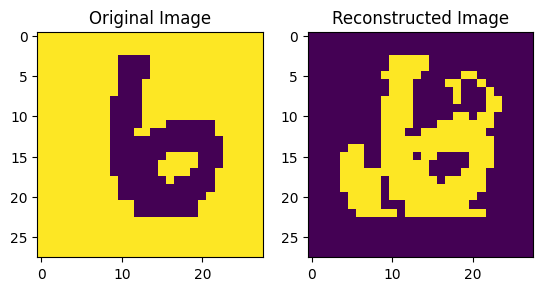

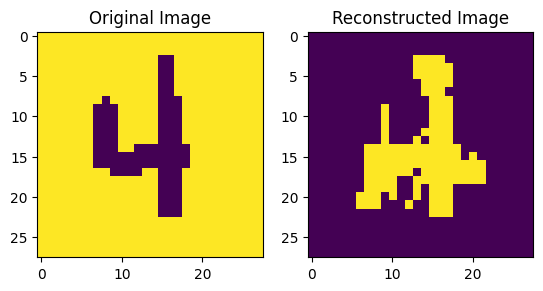

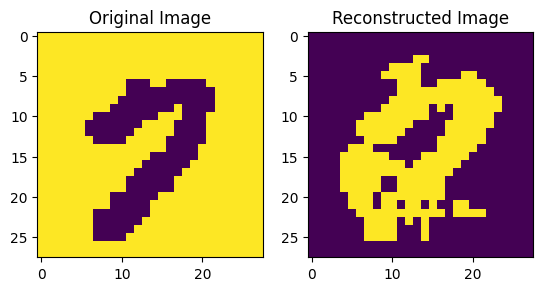

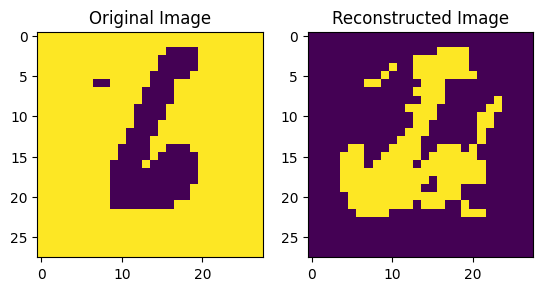

In [ ]:
store_retrieve_N_images(10)

In [ ]:
def demircigil_update_rule(z,xs):
  out = torch.zeros(len(z),1)
  # loop over every element of z
  for i in range(len(z)):
    # initialize accumulators for E_positive and E_negative
    E_pos = 0
    E_neg = 0
    # make copies so we don't mutate the original array
    z_pos = deepcopy(z)
    z_neg = deepcopy(z)
    # try both z[l]^+ and z[l]^-
    z_pos[i] = 1
    z_neg[i] = -1
    # for each stored pattern in xs
    for x in xs:
      # compute positive or negative energies
      E_plus = x.T @ z_pos
      E_minus = x.T @ z_negzp
    if E_pos > E_neg:
      out[i] = 1
    else:
      out[i] = -1
  return out

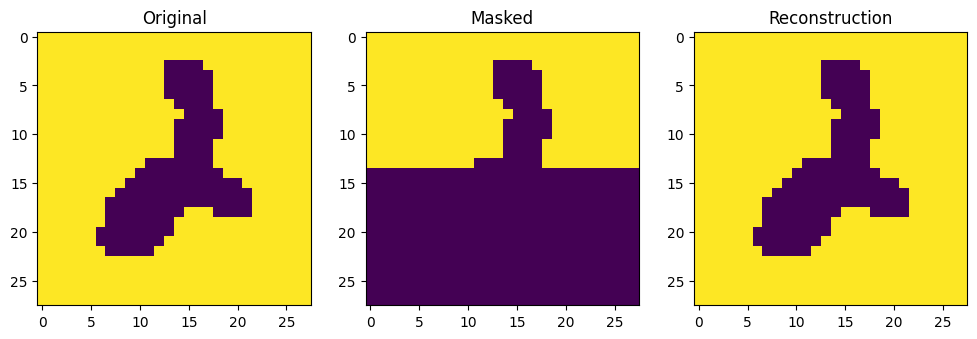

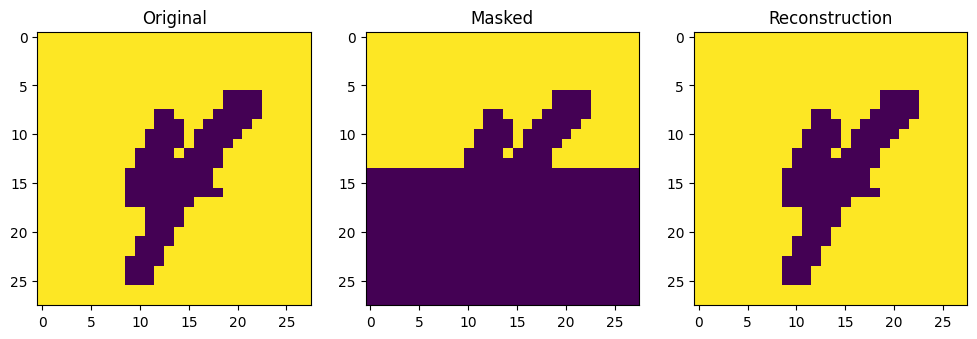

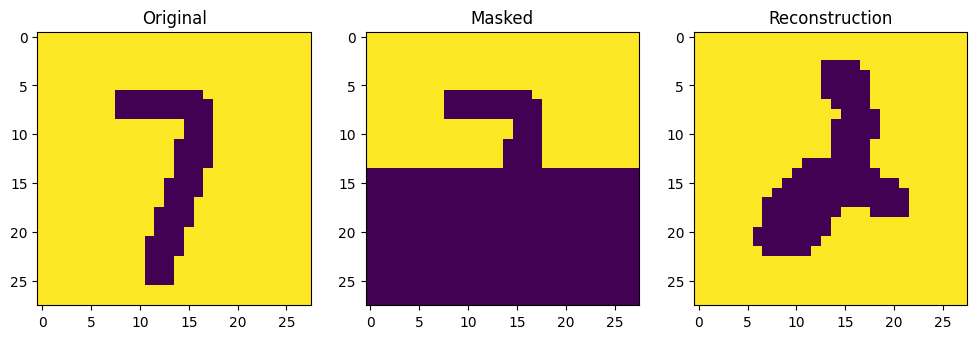

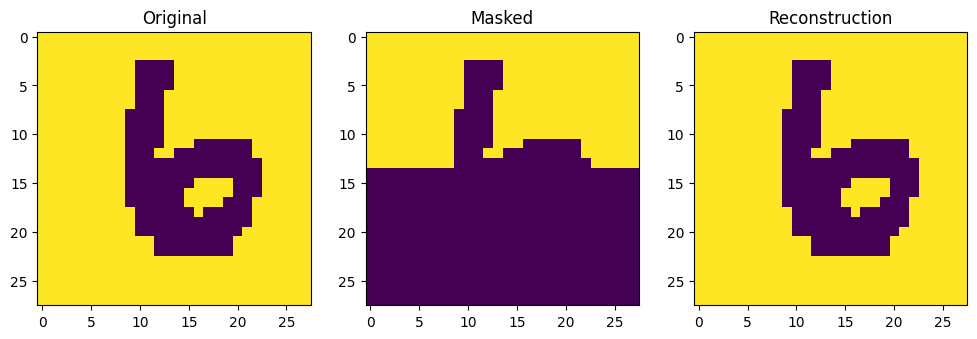

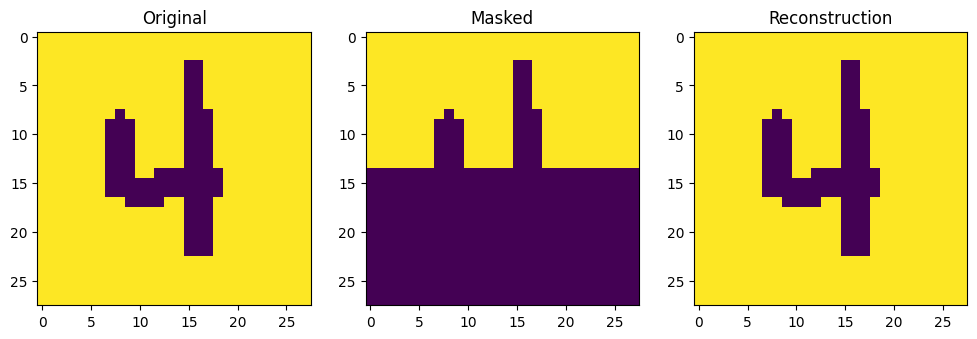

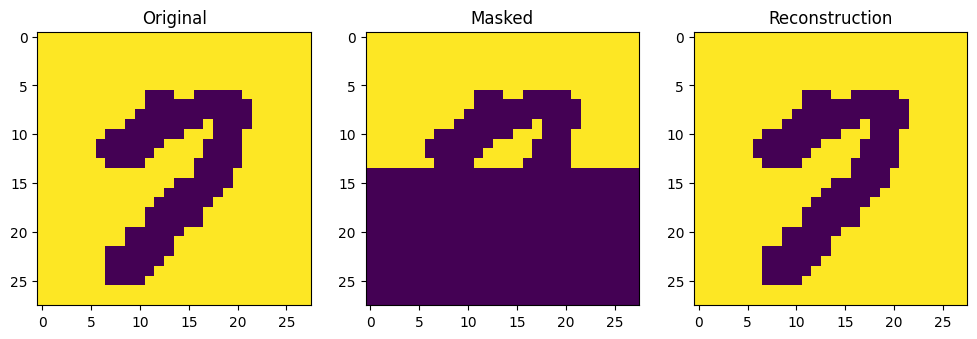

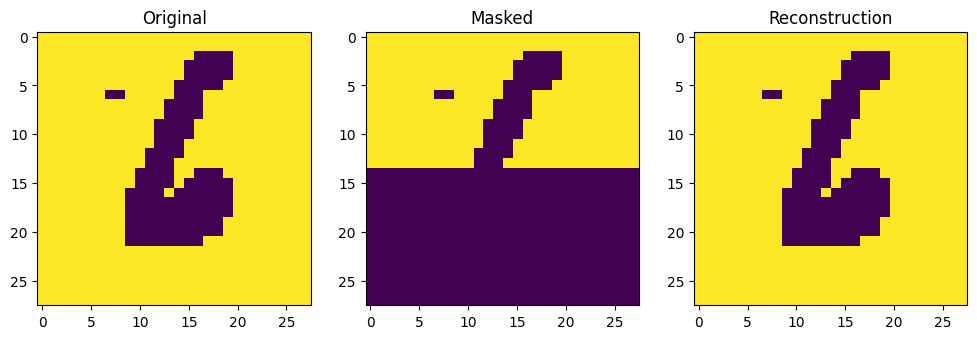

In [23]:
def retrieve_store_demircigil(imgs,N,break_val=-1):
  xs = [binarize(imgs[i,:].reshape(784,1)) for i in range(N)]
  for j in range(N):
    # so we don't print a huge number of images for large stored patterns
    if break_val >0:
      if j > break_val:
        break
    halved_digit = zero_bottom_half(xs[j]).reshape(784,1)
    out = demircigil_update_rule(halved_digit,xs)
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    imgs = [xs[j], halved_digit, out]
    titles = ["Original","Masked","Reconstruction"]
    for i, ax in enumerate(axs.flatten()):
      plt.sca(ax)
      plt.imshow(imgs[i].reshape(28,28))
      plt.title(titles[i])
    plt.show()


retrieve_store_demircigil(imgs,10)

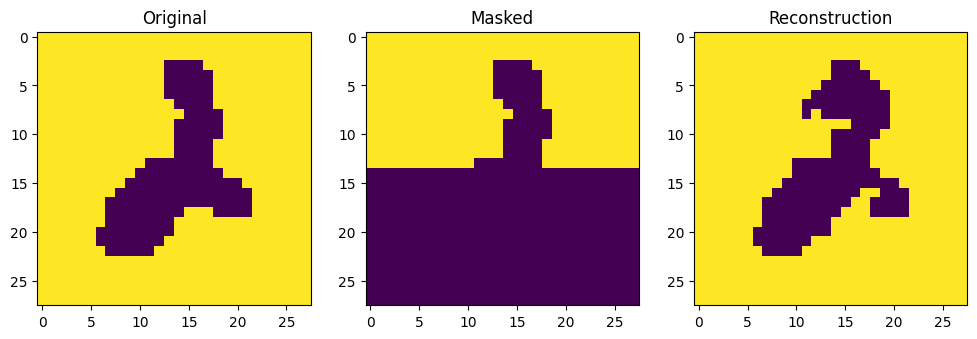

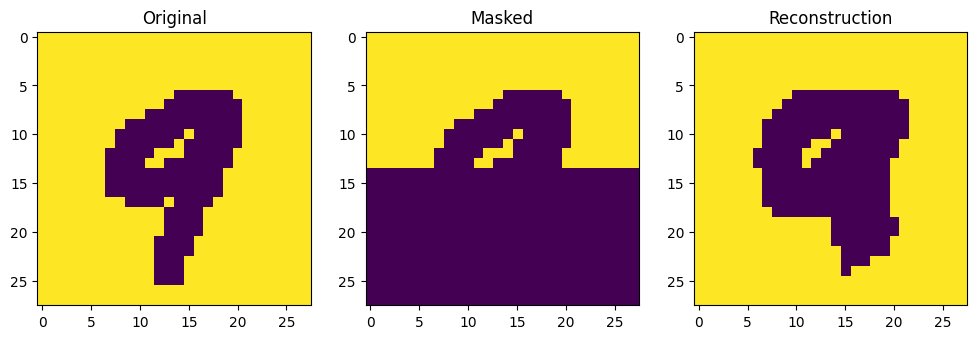

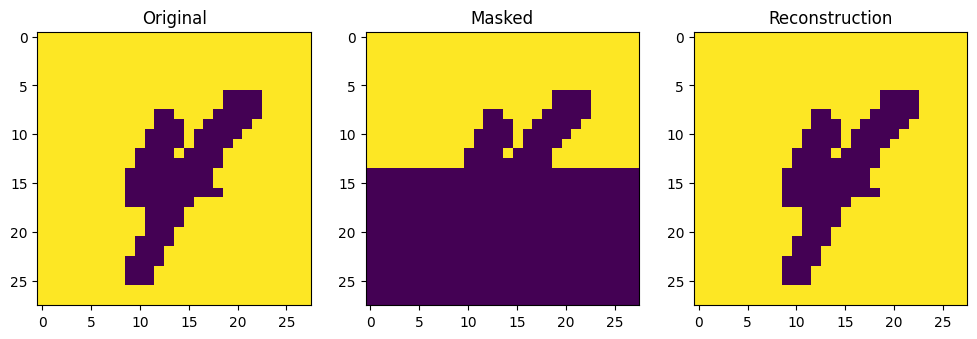

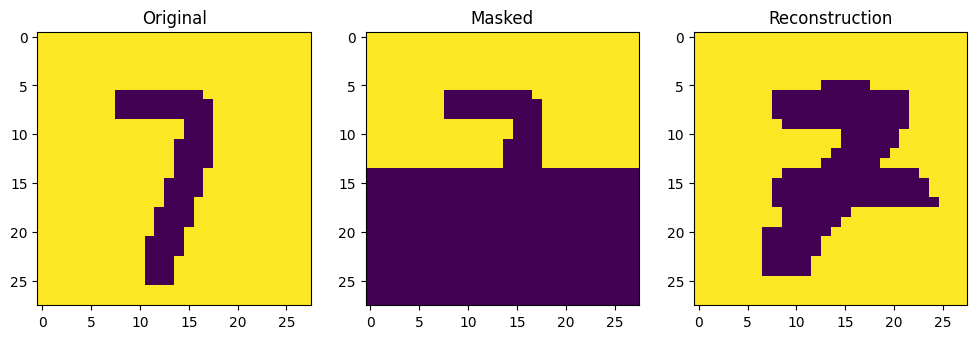

In [24]:
retrieve_store_demircigil(imgs, 100,5)

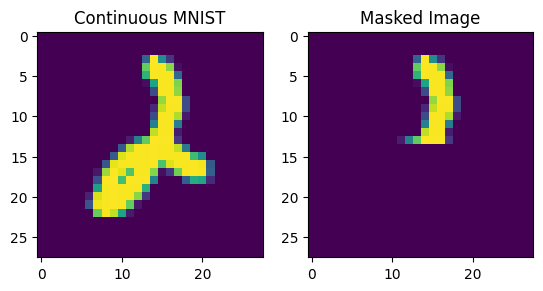

In [25]:
def halve_continuous_img(img):
  H,W = img.reshape(28,28).shape
  i = deepcopy(img.reshape(28,28))
  i[H//2:H,:] = 0
  return i

xs = [imgs[i,:] for i in range(100)]
plt.subplot(1,2,1)
plt.imshow(xs[0].reshape(28,28))
plt.title("Continuous MNIST")
halved_img = halve_continuous_img(xs[0])
plt.subplot(1,2,2)
plt.title("Masked Image")
plt.imshow(halved_img)
plt.show()


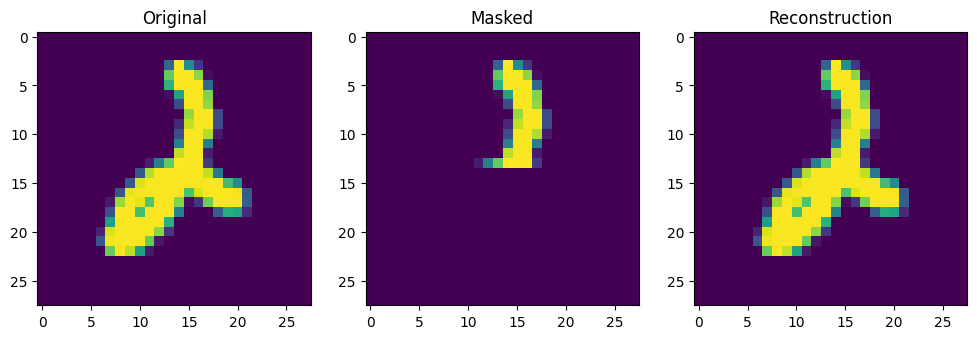

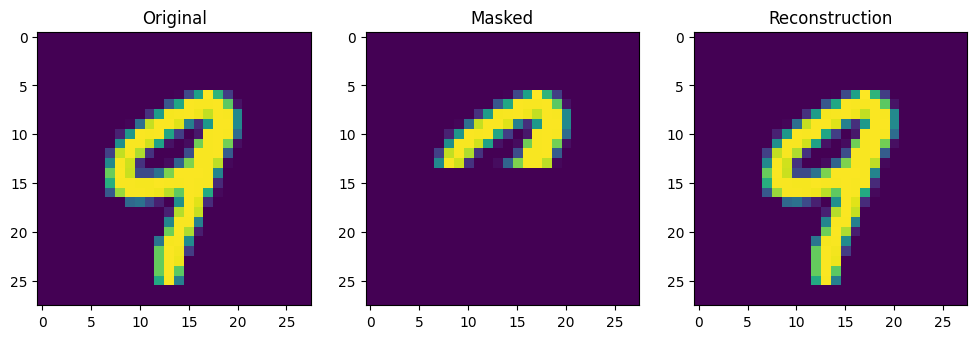

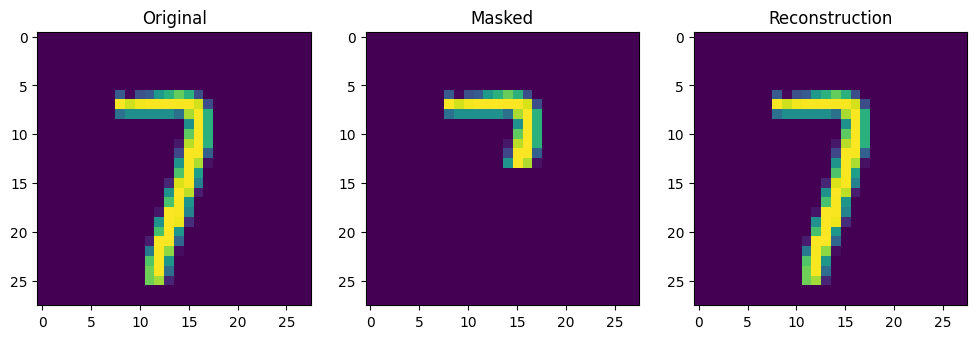

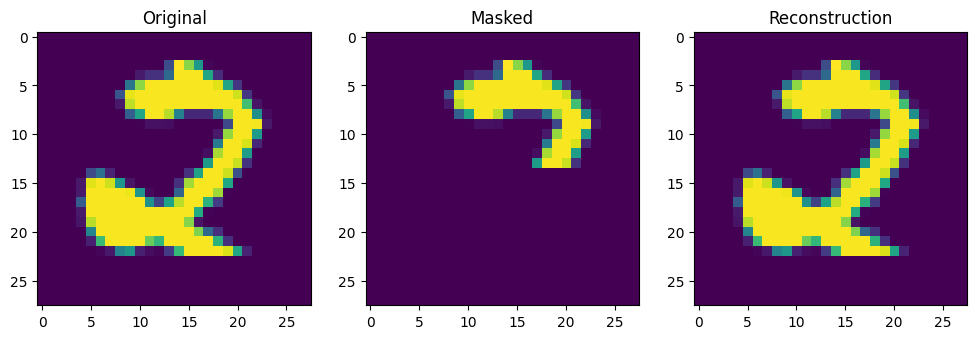

In [26]:
# we next create our weight matrix and then do update rule to retrieve a half pattern
def continuous_update_rule(X,z,beta):
  return X.T @ F.softmax(beta * X @ z,dim=0)

def retrieve_store_continuous(imgs,N, beta=8,num_plot = 5):
  X = imgs[0:N,:]
  for j in range(num_plot):
    z = halve_continuous_img(X[j,:]).reshape(784,1)
    out = continuous_update_rule(X,z,beta)
    # plot
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    imgs = [X[j,:], z, out]
    titles = ["Original","Masked","Reconstruction"]
    for i, ax in enumerate(axs.flatten()):
      plt.sca(ax)
      plt.imshow(imgs[i].reshape(28,28))
      plt.title(titles[i])
    plt.show()

retrieve_store_continuous(imgs,10)

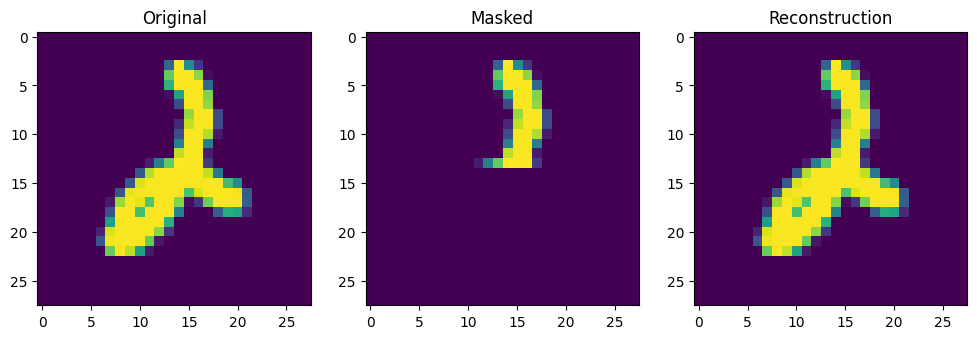

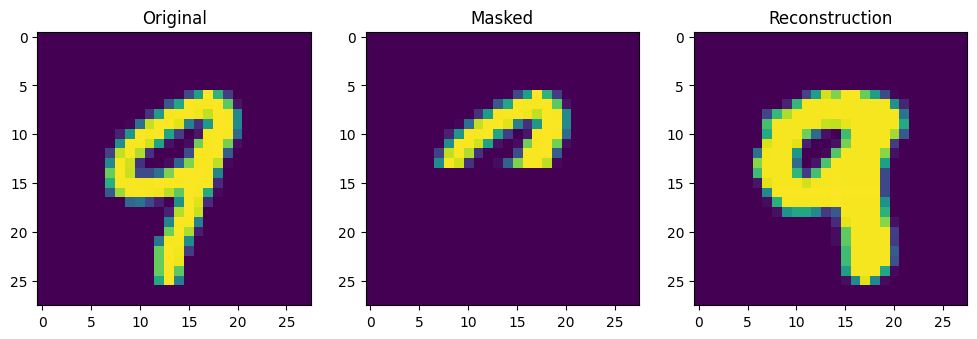

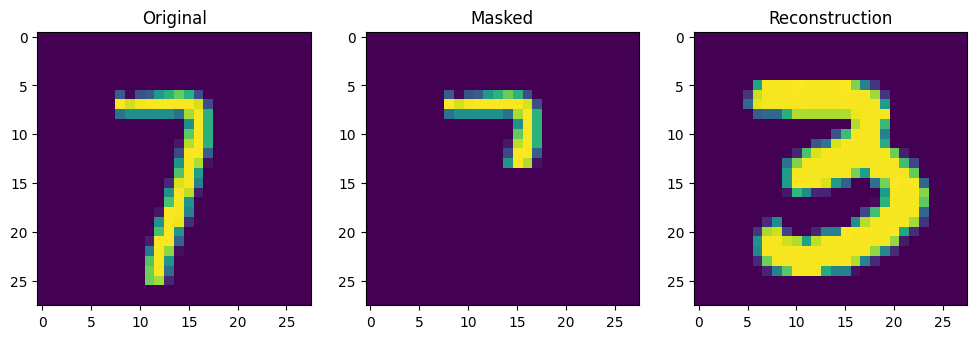

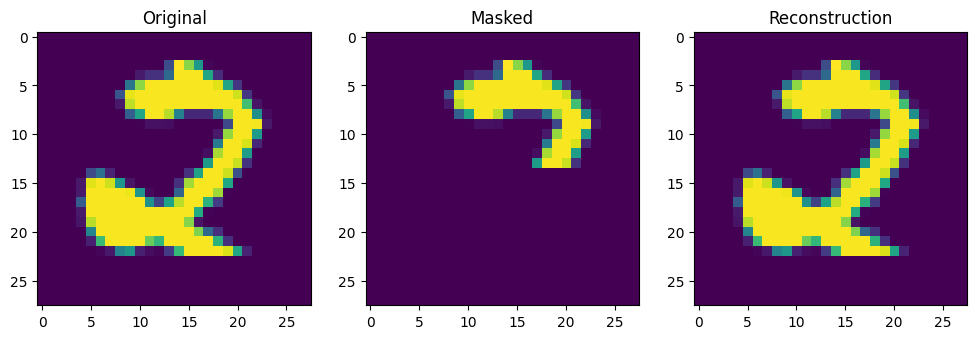

In [27]:
retrieve_store_continuous(imgs, 100)

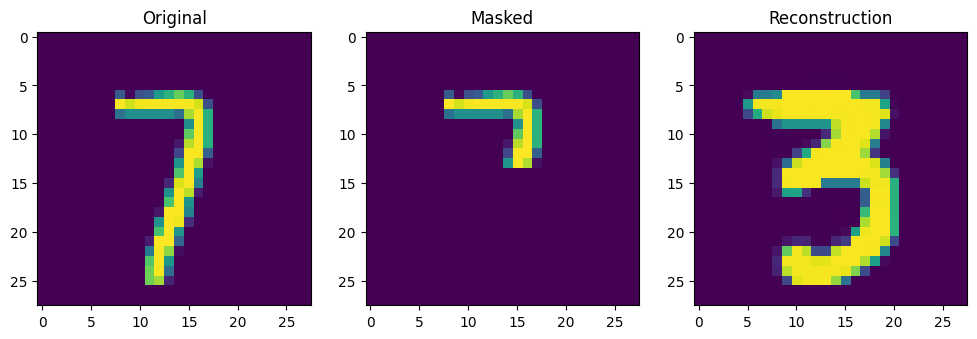

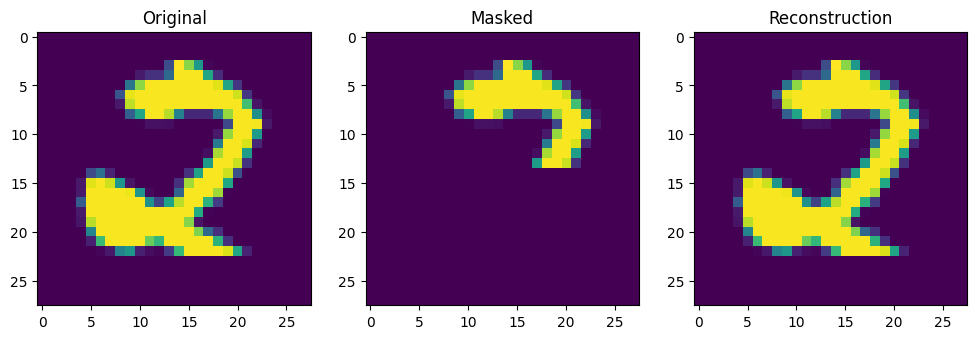

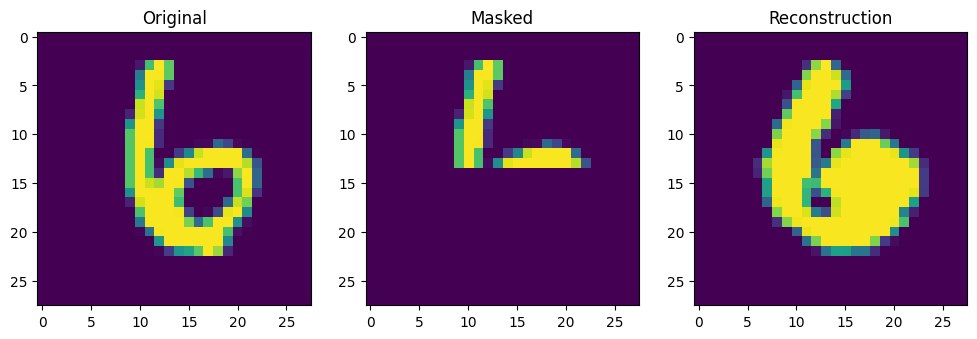

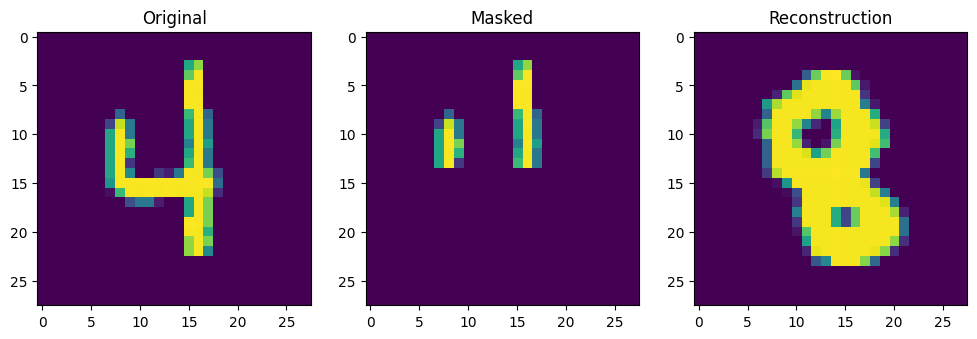

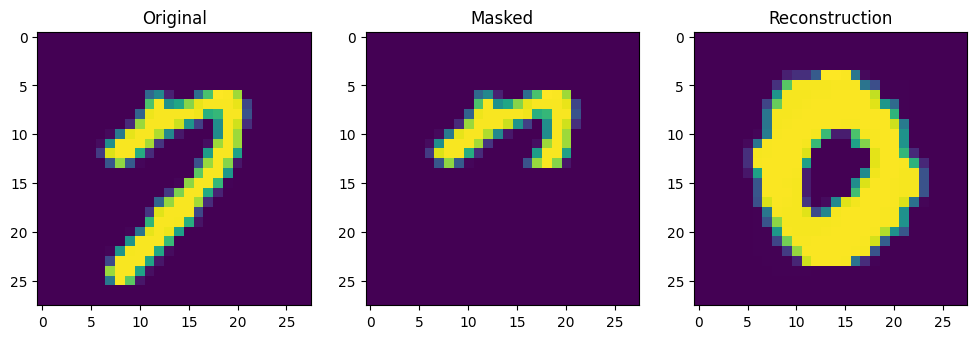

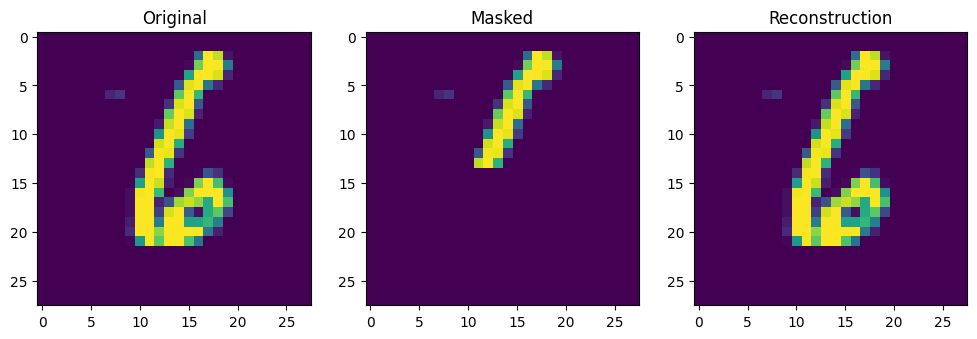

In [28]:
retrieve_store_continuous(imgs, 1000, num_plot=10)

Beta:  0.1


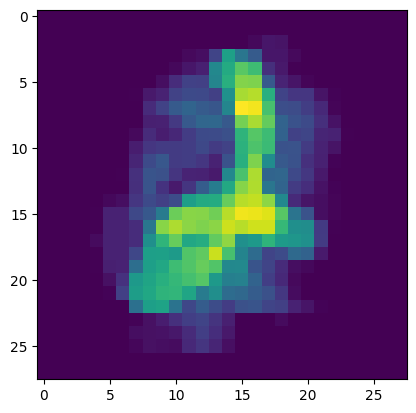

Beta:  0.2


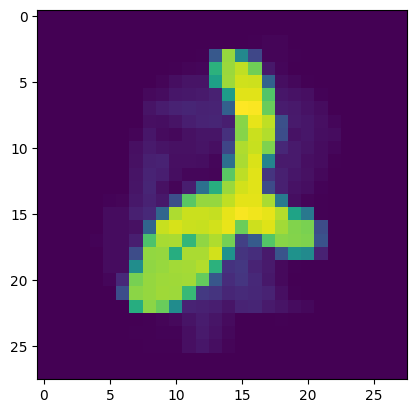

Beta:  0.5


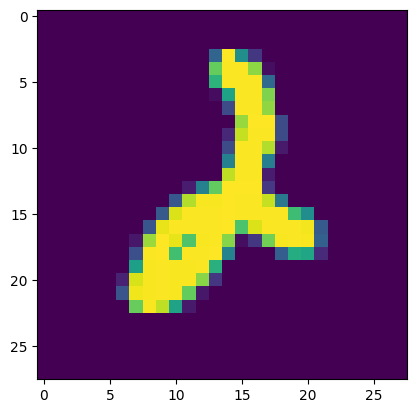

Beta:  1


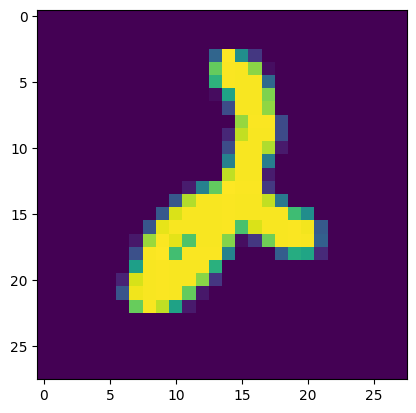

Beta:  2


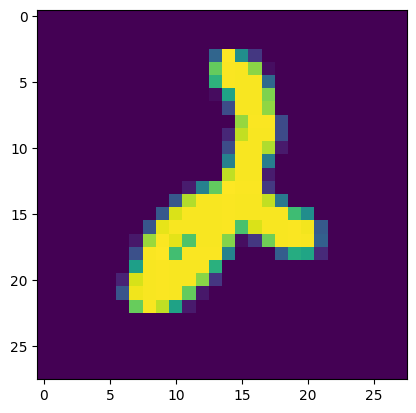

Beta:  4


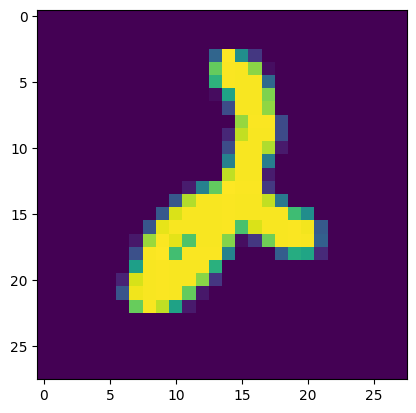

Beta:  8


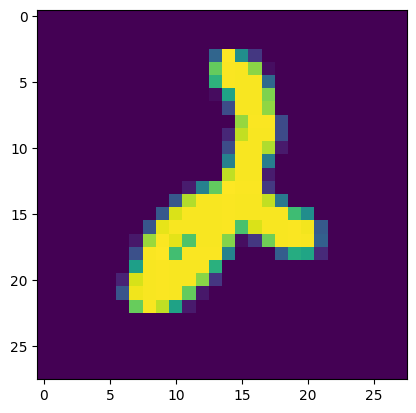

In [29]:
# check effects of beta
betas = [0.1,0.2,0.5,1,2,4,8]
X = imgs[0:10,:]
z = halve_continuous_img(X[0,:]).reshape(784,1)
for beta in betas:
  print("Beta: ", beta)
  out = continuous_update_rule(X,z,beta)
  out = out.reshape(28,28)
  plt.imshow(out)
  plt.show()